In [1]:
import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
from pyprob.model import Parallel_Generator
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

import sklearn as skl
from sklearn.linear_model import LinearRegression

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = to_tensor(x)
    y = torch.stack(y)
    return sinkhorn(x,y)


def ot_dist(x,y):
    # x = to_tensor(x)
    # y = torch.stack(y)
    x = np.array(x)
    y = np.array(torch.stack(y))
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    #Mat1 /= Mat1.max()
    distance = to_tensor(ot.emd2(a,b,Mat))
    return distance


device = "cpu"

from pyprob.util import set_device
set_device(device)

# obs_leaves = to_tensor([[ 25.8005,  15.8486,  13.7905,  14.9743],
#         [ 64.6767,  39.8886,  34.8096,  37.1519],
#         [112.1183,  68.9756,  59.4660,  65.3958],
#         [ 17.2854,   9.8922,   9.2324,  10.7553],
#         [  8.0760,   4.8046,   4.1940,   4.9540],
#         [ 32.6218,  17.6533,  21.0402,  17.6020],
#         [ 78.1670,  42.4337,  50.0361,  42.4953],
#         [ 23.3093,  12.4575,  14.6925,  13.1246],
#         [  8.5133,   4.5174,   5.0757,   5.1276],
#         [ 17.5119,   8.7775,  10.6228,  10.8064],
#         [ 11.6579,   5.0303,   7.2342,   7.6330],
#         [  0.8138,   0.3167,   0.5029,   0.5491],
#         [  0.5715,   0.3441,   0.2433,   0.3707]])

obs_leaves = torch.tensor([[44.57652381, 26.16169856, 25.3945314 , 25.64598258],
       [18.2146321 , 10.70465096, 10.43553391, 10.40449709],
       [ 6.47106713,  4.0435395,  3.65545951,  3.48697568],
       [ 8.43764314,  5.51040615,  4.60990593,  4.42270416],
       [26.61664145, 16.55894826, 14.3357362 , 15.12215264],
       [ 8.62925002,  3.37121204,  5.19699   ,  6.00480461],
       [ 1.64291837,  0.74506775,  1.01003622,  1.05626017],
       [ 0.75525072,  0.3051808 ,  0.45721085,  0.51760643],
       [39.5749915 , 18.39638928, 24.24717939, 25.29349408],
       [ 4.18355659,  2.11145474,  2.82071304,  2.25221316],
       [ 0.82932922,  0.29842766,  0.5799056 ,  0.509021  ],
       [ 3.00825023,  1.36339397,  1.99203677,  1.79428211],
       [ 7.20024308,  4.03280868,  3.82379277,  4.57441754],
       [ 2.09953618,  1.28473579,  1.03554351,  1.29769683],
       [12.21401828,  6.76059035,  6.94920042,  7.42823701],
       [ 6.91438054,  3.68417135,  3.83782514,  4.41656731],
       [ 1.97218904,  1.01632927,  1.08008339,  1.27454585],
       [ 8.58164301,  5.06157833,  4.79691164,  4.99553141],
       [ 5.97809522,  3.26557958,  3.4253764 ,  3.64894791],
       [ 5.22842301,  2.94437891,  3.10292633,  3.00551074],
       [15.40023764,  9.10884407,  8.93836964,  8.61970667],
       [ 1.96101346,  1.24996337,  1.06923988,  1.06743143],
       [19.81054106, 11.90268453, 11.60989346, 10.76953856],
       [18.79470876, 11.429855  , 10.8377334 , 10.25112761],
       [25.74331932, 15.63430056, 14.83860792, 14.07189108],
       [ 9.98357576,  6.10090721,  5.68664128,  5.48748692],
       [12.34604239,  7.78770185,  6.76075998,  6.78498685],
       [21.24998531, 12.95180254, 11.9511704 , 11.87319933],
       [ 7.80693733,  4.83117128,  4.27443559,  4.39602348],
       [16.28983576,  9.66683929,  9.24891886,  9.28970032],
       [ 2.50706736,  1.53153206,  1.36060018,  1.43002765],
       [ 3.73938645,  2.06006639,  2.31013974,  2.09378969],
       [20.2174725 , 11.88622367, 12.05106468, 11.05325362],
       [ 9.48660008,  5.53665456,  5.54171966,  5.34966654],
       [ 2.65812987,  1.64102742,  1.67392209,  1.25083707]], dtype=torch.float64)


QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100



class SimulatorModelDIS(invMass_ginkgo.SimulatorModel, ModelDIS):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def dummy_bernoulli(self, jet):
        return True

    def forward(self, inputs=None):
        assert inputs is None # Modify code if this ever not met?
        # Sample parameter of interest from Unif(0,10) prior
        root_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
                                  name="decay_rate_parameter")
        decay_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
                                   name="decay_rate_parameter")
        # Simulator code needs two decay rates for (1) root note (2) all others
        # For now both are set to the same value
        inputs = [root_rate, decay_rate]
        jet = super().forward(inputs)
        delta_val = self.dummy_bernoulli(jet)
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name = "dummy")
        return jet

# Make instance of the simulator
simulatorginkgo = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True,
                                    obs_leaves=obs_leaves,
                                    dist_fun=sinkhorn_t)

### Load posteriors

In [3]:
posteriors = []
for i in [20,40,69]:
    with open(f'network_parallel_23/LSTM_posterior_{i}', 'rb') as f:
        posterior = pickle.load(f)
        posteriors.append(posterior)

In [4]:
def posterior_result_weight(posterior):
    results = np.array([trace.result['Lambda'].cpu() for trace in posterior])
    weights = posterior.weights_numpy()
    return (results, weights)

# Plot

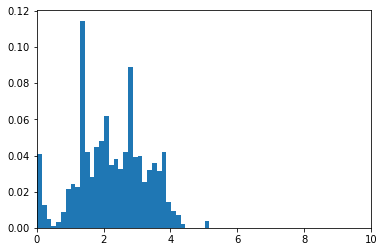

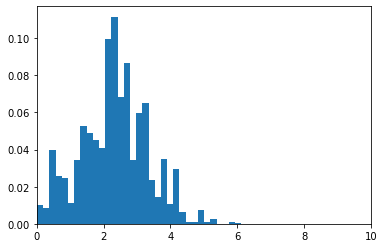

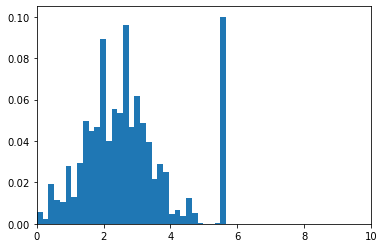

<Figure size 432x288 with 0 Axes>

In [5]:
for posterior in posteriors:
    results, weight = posterior_result_weight(posterior)
    plt.xlim([0,10])
    plt.hist(results, weights=weight, bins=40)
    plt.figure()


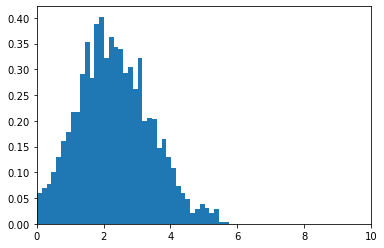

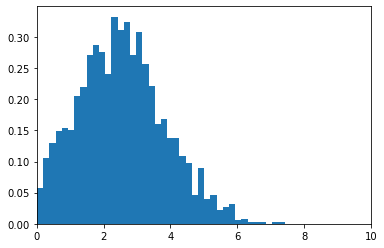

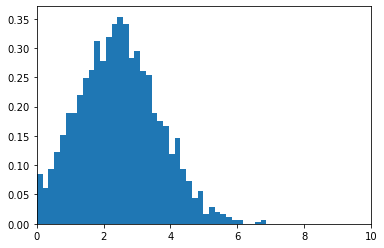

<Figure size 432x288 with 0 Axes>

In [6]:
for posterior in posteriors:
    results, weight = posterior_result_weight(posterior)
    plt.xlim([0,10])
    plt.hist(results, density=True, bins=40)
    plt.figure()


In [7]:
def posterior_result_weight_2(posterior):
    results = np.array([trace.result['LambdaRoot'].cpu() for trace in posterior])
    weights = posterior.weights_numpy()
    return (results, weights)

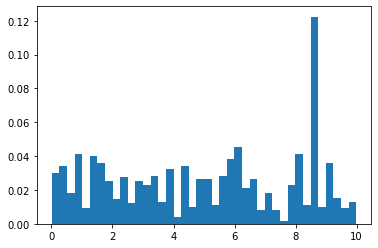

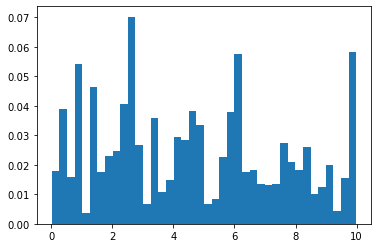

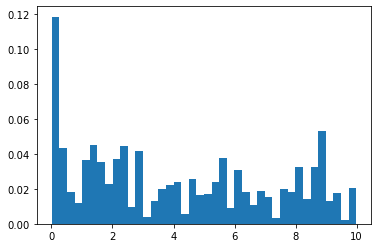

In [8]:
for posterior in posteriors:
    results, weight = posterior_result_weight_2(posterior)
    plt.figure()
    plt.hist(results, weights=weight, bins=40)

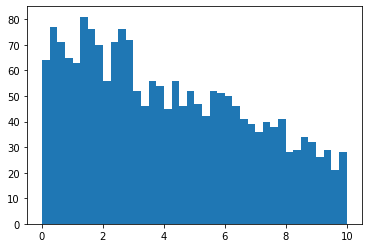

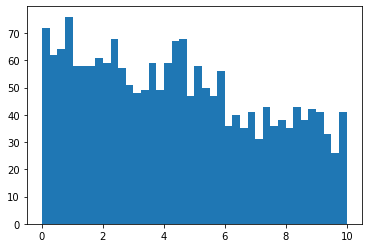

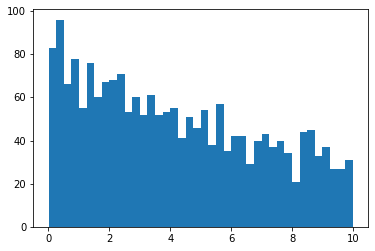

In [9]:
for posterior in posteriors:
    results, weight = posterior_result_weight_2(posterior)
    plt.figure()
    plt.hist(results, bins=40)

In [16]:
with open(f'network_parallel_15/LSTM_posterior_16', 'rb') as f:
    posterior = pickle.load(f)
    posteriors.append(posterior)

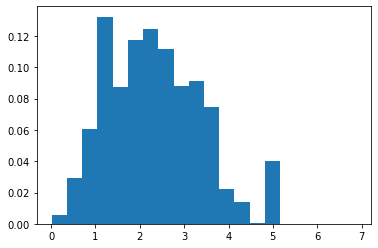

In [20]:
results, weight = posterior_result_weight(posterior)
plt.figure()
plt.hist(results, weights=weight, bins=20)
plt.show()

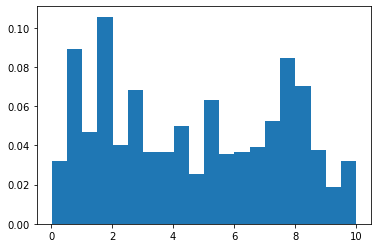

In [21]:
results, weight = posterior_result_weight_2(posterior)
plt.figure()
plt.hist(results, weights=weight, bins=20)
plt.show()

## Profiling

In [2]:
import pstats
from pstats import SortKey

In [25]:
p = pstats.Stats('cprofile_output_1')
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(50)

Mon May 23 15:33:33 2022    cprofile_output_1

         1685687838 function calls (1672237587 primitive calls) in 25404.345 seconds

   Ordered by: cumulative time
   List reduced from 643 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000 25404.345 25404.345 {built-in method builtins.exec}
        1    0.000    0.000 25404.345 25404.345 <string>:1(<module>)
        1    8.232    8.232 25404.345 25404.345 dis.py:134(train)
        1    0.000    0.000 25396.113 25396.113 model.py:348(learn_inference_network)
        1  295.611  295.611 23476.150 23476.150 inference_network.py:381(optimize)
       64  197.617    3.088 13840.020  216.250 inference_network_lstm.py:140(_loss)
       64    0.005    0.000 9182.299  143.473 _tensor.py:307(backward)
       64    0.003    0.000 9182.294  143.473 __init__.py:85(backward)
       64 9182.287  143.473 9182.287  143.473 {method 'run_backward' of 'torch._C._EngineBase' obj

In [26]:
p.strip_dirs().sort_stats(SortKey.TIME).print_stats(50)

Mon May 23 15:33:33 2022    cprofile_output_1

         1685687838 function calls (1672237587 primitive calls) in 25404.345 seconds

   Ordered by: internal time
   List reduced from 643 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       64 9182.287  143.473 9182.287  143.473 {method 'run_backward' of 'torch._C._EngineBase' objects}
 16701900 1707.454    0.000 3556.350    0.000 normal.py:79(cdf)
 43900357 1251.674    0.000 1251.674    0.000 {method 'all' of 'torch._C._TensorBase' objects}
  8350950 1008.784    0.000 6928.240    0.001 truncated_normal.py:11(__init__)
  8350950  947.714    0.000 2046.651    0.000 normal.py:71(log_prob)
 25901581  912.014    0.000 2098.855    0.000 distribution.py:248(_validate_sample)
  8350950  680.449    0.000 4593.426    0.001 truncated_normal.py:40(log_prob)
 33408198  503.995    0.000  503.995    0.000 constraints.py:307(check)
 10435027  410.850    0.000 1129.010    0.000 util.py:230(has_na

In [5]:
p2 = pstats.Stats('cprofile_output_8')
p2.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(100)

Thu May 26 04:30:27 2022    cprofile_output_8

         1578253060 function calls (1568408009 primitive calls) in 16840.166 seconds

   Ordered by: cumulative time
   List reduced from 456 to 100 due to restriction <100>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.012    0.012 16840.166 16840.166 {built-in method builtins.exec}
        1    0.000    0.000 16840.153 16840.153 <string>:1(<module>)
        1    7.900    7.900 16840.153 16840.153 dis.py:134(train)
        1    0.000    0.000 16832.253 16832.253 model.py:348(learn_inference_network)
        1    0.000    0.000 16179.417 16179.417 dataset.py:88(__init__)
        1    0.000    0.000 16048.981 16048.981 model.py:107(_dis_traces)
        1    0.911    0.911 16048.981 16048.981 model.py:197(_traces)
     8256    0.021    0.000 16043.305    1.943 {built-in method builtins.next}
     8193    0.095    0.000 16043.258    1.958 model.py:98(_trace_generator)
     8192    9.435    0.001 16016

In [4]:
p2.strip_dirs().sort_stats(SortKey.TIME).print_stats(50)

Thu May 26 04:30:27 2022    cprofile_output_8

         1578253060 function calls (1568408009 primitive calls) in 16840.166 seconds

   Ordered by: internal time
   List reduced from 456 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 12997060 1302.810    0.000 2527.352    0.000 normal.py:79(cdf)
 34149697  944.207    0.000  944.207    0.000 {method 'all' of 'torch._C._TensorBase' objects}
  6332410  855.648    0.000 3956.066    0.001 truncated_normal.py:94(sample)
 20771271  781.002    0.000 2117.752    0.000 util.py:230(has_nan_or_inf)
  6498530  771.750    0.000 5116.117    0.001 truncated_normal.py:11(__init__)
  6498530  717.349    0.000 1566.451    0.000 normal.py:71(log_prob)
 20754887  658.090    0.000  658.090    0.000 {built-in method isinf}
 87307718  657.456    0.000  657.456    0.000 {method 'to' of 'torch._C._TensorBase' objects}
  6332410  583.526    0.000  689.017    0.000 normal.py:84(icdf)
 29353012  539.402    0

# Dataset test

In [30]:
simulatorginkgoprior = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True,
                                    obs_leaves=obs_leaves,
                                    dist_fun=sinkhorn_t)

In [49]:
dataset = OnlineDataset(simulatorginkgoprior,length=1000, inference_engine = InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, inference_network = None, importance_sample_size = 1000, num_workers=1, ess_target = 500)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:01:44 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 9.58       


In [50]:
results = []
log_weights = []
for i in range(1000):
    trace = dataset[i]
    results.append(trace.result['Lambda'].detach().numpy())
    log_weights.append(trace.log_importance_weight)

In [82]:
traces= simulatorginkgoprior._dis_traces(
                num_traces=1000,
                inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,
                observe={"dummy": 1},
                num_workers = 4)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:01:43 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 9.62       


In [83]:
traces._categorical.logits

tensor([-6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078, -6.9078,
        -6.9078, -6.9078, -6.9078, -6.90

In [86]:
traces._categorical.probs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 

In [87]:
traces.weights

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 

In [88]:
simulatorginkgoprior.update_DIS_weights(traces)

Empirical(items:1000, weighted:False)

In [89]:
traces._categorical.logits

tensor([ -21.6879,  -17.3491,  -36.6432,   -7.9277,  -14.0398,   -7.6781,
         -31.1890,   -7.1808,   -8.5350,   -7.4057,   -9.2406,  -11.4537,
          -7.1612,  -25.5693,   -7.2315,   -9.2615,   -7.1791,  -14.2828,
         -25.8906,  -11.3743,   -8.1185,  -14.5284,   -8.2660,   -7.8342,
          -7.8456,   -7.9829,   -6.9831,   -7.0542,   -6.9772,   -7.5438,
          -7.2729,   -6.9817,  -13.2117,   -7.1212,   -9.9674,   -8.3138,
          -7.0438,   -8.2212,   -7.1581,   -8.4023,   -7.0356,   -7.2390,
          -7.1890,   -7.0418,  -21.4094,   -9.6646,   -8.6639,   -6.9798,
          -7.1028,   -7.1446,  -61.3316,   -7.1064,   -7.9019,   -7.0798,
          -7.0133,   -9.0013,   -7.4334,   -8.4813,   -7.1046,   -7.5853,
          -7.0362,   -7.3382,  -12.7860,   -7.7977,   -7.3152,  -11.4837,
         -10.1196,  -20.3087,   -8.3031,  -20.9349,   -7.1445,  -25.6597,
          -8.1058,  -32.5959,   -8.5990,  -10.7230,  -26.8772,  -11.1644,
         -12.7150,   -7.0549,  -30.634

In [90]:
traces._categorical.probs

tensor([3.8112e-10, 2.9199e-08, 1.2191e-16, 3.6063e-04, 7.9905e-07, 4.6288e-04,
        2.8495e-14, 7.6103e-04, 1.9648e-04, 6.0780e-04, 9.7023e-05, 1.0610e-05,
        7.7611e-04, 7.8594e-12, 7.2342e-04, 9.5017e-05, 7.6235e-04, 6.2667e-07,
        5.6997e-12, 1.1487e-05, 2.9797e-04, 4.9020e-07, 2.5711e-04, 3.9596e-04,
        3.9147e-04, 3.4124e-04, 9.2739e-04, 8.6374e-04, 9.3291e-04, 5.2940e-04,
        6.9410e-04, 9.2871e-04, 1.8290e-06, 8.0781e-04, 4.6903e-05, 2.4512e-04,
        8.7284e-04, 2.6889e-04, 7.7851e-04, 2.2435e-04, 8.7999e-04, 7.1805e-04,
        7.5483e-04, 8.7454e-04, 5.0351e-10, 6.3490e-05, 1.7271e-04, 9.3047e-04,
        8.2278e-04, 7.8908e-04, 2.3122e-27, 8.1985e-04, 3.7005e-04, 8.4197e-04,
        8.9986e-04, 1.2325e-04, 5.9120e-04, 2.0730e-04, 8.2130e-04, 5.0786e-04,
        8.7946e-04, 6.5025e-04, 2.7996e-06, 4.1068e-04, 6.6533e-04, 1.0296e-05,
        4.0281e-05, 1.5137e-09, 2.4774e-04, 8.0923e-10, 7.8923e-04, 7.1805e-12,
        3.0177e-04, 6.9785e-15, 1.8428e-

In [92]:
traces.weights.sum()

tensor(0.3352, dtype=torch.float64)

In [ ]:
posteriors

In [25]:
posteriors[0].weights_numpy()

array([7.74087531e-03, 5.31802311e-09, 1.88755990e-10, ...,
       1.76156460e-04, 1.21986334e-03, 2.89106453e-18])

In [28]:
with open(f'network_parallel_15/LSTM_posterior_20', 'rb') as f:
    posterior = pickle.load(f)
    posteriors.append(posterior)

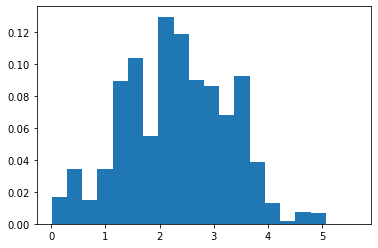

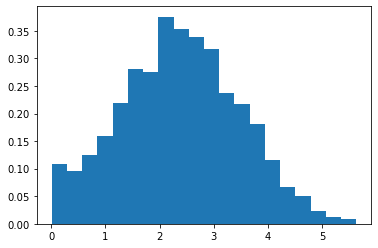

In [29]:
results, weight = posterior_result_weight(posterior)
plt.figure()
plt.hist(results, weights=weight, bins=20)
plt.figure()
plt.hist(results,bins=20,density=True)
plt.show()